# **The Vehicle Type Classification Project**



# Summary


- **Use Case:** Vehicle Type
- **Algorithm:** MobileNetV2
- **Number of training images:** 603
- **Number of classes:** 7
- **Batch Size:** 64
- **Optimizer:** Adam 
- **Learning Rate:** 0.0001
- **Loss Type:**CategoricalCrossentropy
- **Transfer Learning:** Yes | Imagenet



 ## Labels
 
 0: 'car-bus-alltypes',

 1: 'car-sedan-alltypes',
 
 2: 'car-suv-alltypes',
 
 3: 'motocycle-bicycle-kids',
 
 4: 'motocycle-bicycle-racing',
 
 5: 'motocycle-motorbike-chopper',
 
 6: 'motocycle-motorbike-sport'

## Import Library

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [ ]:
print(tf.__version__)

2.4.1


## 구글드라이브 마운트 하기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#구글 드라이브에 워킹 디렉토리 경로 설정
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep Learning')

In [5]:
#구글 드라이브에 데이터파일 다운로드
!wget --no-check-certificate \
    https://block-yh-test1.s3.amazonaws.com/38_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%91%E1%85%A1%E1%84%8B%E1%85%B5%E1%86%AF.zip \
    -O ./vehicle_type_classification.zip

--2022-06-16 05:34:18--  https://block-yh-test1.s3.amazonaws.com/38_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%91%E1%85%A1%E1%84%8B%E1%85%B5%E1%86%AF.zip
Resolving block-yh-test1.s3.amazonaws.com (block-yh-test1.s3.amazonaws.com)... 54.231.204.217
Connecting to block-yh-test1.s3.amazonaws.com (block-yh-test1.s3.amazonaws.com)|54.231.204.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326052257 (311M) [application/zip]
Saving to: ‘./vehicle_type_classification.zip’

./vehicle_type_clas 100%[===================>] 310.95M  13.1MB/s    in 27s     

2022-06-16 05:34:46 (11.7 MB/s) - ‘./vehicle_type_classification.zip’ saved [326052257/326052257]



In [6]:
#리눅스 명령어로 압축파일 풀기
! unzip vehicle_type_classification.zip

Archive:  vehicle_type_classification.zip
   creating: test-images/
  inflating: __MACOSX/._test-images  
  inflating: test-images/bicycle.png  
  inflating: __MACOSX/test-images/._bicycle.png  
  inflating: test-images/bus.jpg     
  inflating: __MACOSX/test-images/._bus.jpg  
   creating: trained-models/
  inflating: __MACOSX/._trained-models  
   creating: trained-models/mobilenetv2/
  inflating: __MACOSX/trained-models/._mobilenetv2  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehic

## 경로 셋팅

In [7]:
TYPE='type'
model_type='mobilenetv2'
user='block'
iteration='1-1'

first_time_training=True

PROJECT_PATH= '.'

HDF5_DATASET_PATH=PROJECT_PATH+'/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5'

TARGET_CLASSIFICATION_MODEL=PROJECT_PATH+'/trained-models/'+model_type+'/'+'vehicle-classification-by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

CHECKPOINT_PATH = PROJECT_PATH+'/checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

LOGFILE_PATH=PROJECT_PATH+'/log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'


In [8]:
print('PROJECT_PATH: ',PROJECT_PATH)
print('HDF5_DATASET_PATH: ', HDF5_DATASET_PATH)
print('TARGET_CLASSIFICATION_MODEL: ',TARGET_CLASSIFICATION_MODEL)
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)
print('LOGFILE_PATH: ',LOGFILE_PATH)

PROJECT_PATH:  .
HDF5_DATASET_PATH:  ./vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5
TARGET_CLASSIFICATION_MODEL:  ./trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-block-1-1.h5
CHECKPOINT_PATH:  ./checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-1.h5
LOGFILE_PATH:  ./log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-1.csv


In [9]:
sys.path.append(PROJECT_PATH)

# **Load the Dataset**

In [10]:
def load_dataset_from_hdf5_file(hdf_file_path):
  # 함수 만들기
  hf = h5py.File(hdf_file_path, 'r')

  X_train = np.array(hf['trainX'])
  y_train = np.array(hf['trainY'])
  train_label = np.array(hf['trainLabels'])

  X_test = np.array(hf['testX'])
  y_test = np.array(hf['testY'])
  test_label = np.array(hf['testLabels'])

  X_val = np.array(hf['devX'])
  y_val = np.array(hf['devY'])
  val_label = np.array(hf['devLabels'])

  return X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label

In [68]:
X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label=load_dataset_from_hdf5_file(HDF5_DATASET_PATH)

In [15]:
X_train.shape

(603, 224, 224, 3)

In [16]:
y_train.shape

(603, 7)

In [ ]:
train_label

In [18]:
X_val.shape

(75, 224, 224, 3)

# 사진이미지 확인해 보기

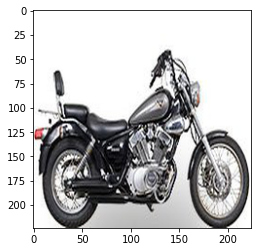

In [19]:
plt.imshow(X_train[0])

In [20]:
y_train[0]

array([0, 0, 0, 0, 0, 1, 0])

In [21]:
train_label[0]

b'motocycle-motorbike-chopper'

In [ ]:
#이 데이터는 이미 피쳐스케일링 되어 있다.

# 모델링하기 : 트랜스퍼 러닝 적용

# Data Augmentation

# Summary


- **Use Case:** Vehicle Type
- **Algorithm:** MobileNetV2
- **Number of training images:** 603
- **Number of classes:** 7
- **Batch Size:** 64
- **Optimizer:** Adam 
- **Learning Rate:** 0.0001
- **Loss Type:**CategoricalCrossentropy
- **Transfer Learning:** Yes | Imagenet

In [22]:
X_train.shape

(603, 224, 224, 3)

In [50]:
IMG_SHAPE=(224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=1000)
#include_top=False 는 ANN부분은 가져오지 않는다. 즉, 베이스모델만 가져온다.
#프리징한다.
base_model.trainable = False

#베이스모델을 연결할 모델을 정의한다.
head_model=base_model.output

#함수형 모델링
#헤드모델에 flatten 인풋레이어 추가
#head_model=tf.keras.layers.GlobalAveragePooling2D()(head_model)
#헤드모델에 풀링레이어 추가(pool_size=(4,4), stride=(4, 4))
head_model=AveragePooling2D(4, 4)(head_model)

#헤드모델에 flatten 인풋레이어 추가
head_model=Flatten()(head_model)

#헤드모델에 히든레이어 추가
head_model=tf.keras.layers.Dense(512,'relu')(head_model)

#헤드모델에 Dropout레이어 추가
head_model=Dropout(0.2)(head_model)

#헤드모델에 아웃풋레이어 추가
head_model=tf.keras.layers.Dense(7,'softmax')(head_model)

#모델을 합쳐서 모델을 완성한다.
#베이스모델과 헤드모델을 합쳐서, 하나의 모델이라는 변수도 만들어 준다.
model=tf.keras.models.Model(inputs=base_model.input, outputs=head_model)

###  콜백 만들기 : 가장 좋은 모델을 자동 저장하도록 함. 로그도 저장하도록 함.

In [44]:
#파이썬으로 저장할 디렉토리 만들기
if not os.path.exists(PROJECT_PATH+'/checkpoints/'+model_type+'/'):
    os.makedirs(PROJECT_PATH+'/checkpoints/'+model_type+'/')

if not os.path.exists(PROJECT_PATH+'/log/'+model_type+'/'):
    os.makedirs(PROJECT_PATH+'/log/'+model_type+'/')

In [48]:
## ModelCheckpoint 저장 콜백생성(학습 중 정확도가 가장 좋은 모델을 저장)
from tensorflow.keras.callbacks import ModelCheckpoint
cp=ModelCheckpoint(CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

In [49]:
## CSVLogger 저장 콜백생성(에포크가 끝날때 나오는 정보를, 파일로 저장할때 사용)
from tensorflow.keras.callbacks import CSVLogger
csv_logger=CSVLogger(LOGFILE_PATH, append=True)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.999:
            print('\nReached 99.9% accuracy so cancelling training!')
            self.model.stop_training = True

callbacks = myCallback()

In [51]:
#EarlyStopping 콜백생성 : validation loss가 에포크 10번 단위로 성능 향상이 없으면 학습을 멈춰라.
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

## 컴파일과 학습 : 에포크는 50

In [52]:
#컴파일
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
#학습 이미지 증강을 위해서 ImageDataGenerator 를 사용
train_datagen=ImageDataGenerator(rotation_range=20, horizontal_flip=True)

In [69]:
train_generator=train_datagen.flow(X_train, y_train, batch_size=64)

In [ ]:
#학습
epoch_history=model.fit(train_generator, epochs=40, validation_data=(X_val, y_val), callbacks=[cp,csv_logger], steps_per_epoch=10)

# 트레이닝 및 밸리데이션의 정확도와 로스를 차트로 보기

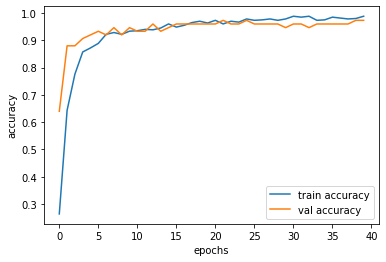

In [60]:
#epoch 정확도 시각화
import matplotlib.pyplot as plt
plt.plot(epoch_history.history['accuracy'])
plt.plot(epoch_history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# 모델 평가

In [61]:
#평가
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 42ms/step - loss: 0.1241 - accuracy: 0.9737


[0.12405874580144882, 0.9736841917037964]

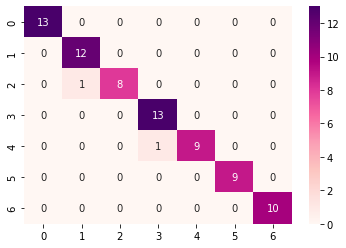

In [62]:
y_pred=model.predict(X_test)
#컨퓨전매트릭스
from sklearn.metrics import confusion_matrix
#레이블 인코딩으로 바꿔야 한다.
y_test_lable=y_test.argmax(axis=1)
y_pred=y_pred.argmax(axis=1)
cm=confusion_matrix(y_test_lable, y_pred)

import seaborn as sb
sb.heatmap(data=cm, annot=True, fmt='.0f', cmap='RdPu')
plt.show()

In [76]:
#fine tuning 해 보자...
#1.베이스모델의 전체 레이어를 학습 가능하도록 먼저 만든다.
base_model.trainable=True
#2.베이스모델의 전체 레이어수를 확인한다.
len(base_model.layers)
#3.몇번째 레이어까지 학습이 안되도록 할지 결정해 준다.(80% 로 해 보자..)
end_layer=int(len(base_model.layers) * .85)
#4.베이스모델의 첫번째 레이어부터, 우리가 정한 레이어까지 학습이 안되도록 설정해 준다.
for layer in base_model.layers[0:end_layer]:
    layer.trainable = False

In [77]:
#컴파일
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#학습
epoch_history=model.fit(train_generator, epochs=20, validation_data=(X_val, y_val), callbacks=[cp,csv_logger], steps_per_epoch=10)

In [79]:
#평가
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 41ms/step - loss: 0.3083 - accuracy: 0.9605


[0.30827176570892334, 0.9605262875556946]